### Урок 4. Деревья решений

**Задача 3**

(\*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

In [2]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np

In [3]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels) 

In [5]:
# Цвета для дальнейшей раскраски хода дерева

class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

In [6]:
# Переделаем код из методички в класс ООП

# Реализуем класс дерева
class Tree:
    
    def __init__(self, min_leaf=None, max_depth=None, max_leaves=None):
        self.min_leaf = min_leaf # минимальное количество объектов в листе
        self.max_depth = max_depth  # максимальная глубина дерева
        self.max_leaves = max_leaves  # максимальное количество листьев
        self.nodes = 0 # построено узлов
        self.leaves = 0 # построено листьев
    
    # Расчет дисперсии
    def dispersion(self, labels):
        return np.var(labels)
    
    # Расчет качества
    def quality(self, left_labels, right_labels, current_dispersion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_dispersion - p * self.dispersion(left_labels) - (1 - p) * self.dispersion(right_labels)
    
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        current_dispersion = self.dispersion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее минимального количества (min_leaf)
                if self.min_leaf:
                    if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                        continue

                current_quality = self.quality(true_labels, false_labels, current_dispersion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
     
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества или срабатывают критерии остановы
        condition = None
        if self.max_depth and self.max_leaves:
            condition = (quality == 0) or (self.nodes >= self.max_depth) or (self.nodes >= self.max_leaves-1)
        elif self.max_depth: 
            condition = (quality == 0) or (self.nodes >= self.max_depth)
        elif self.max_leaves:
            condition = (quality == 0) or (self.nodes >= self.max_leaves-1)
        else: 
            condition = (quality == 0)
        if condition:
            self.leaves +=1
            return Leaf(data, labels)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        self.nodes += 1
            

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
        
    def classify_object(self, obj, node):
        
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def predict(self, data, tree):  
        
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, tree)
            classes.append(prediction)
        return classes
    
    
    # Напечатаем ход нашего дерева
    def print_tree(self, node, spacing=""):  

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                      + ': прогноз = ' + str(node.prediction) 
                      + ', объектов = ' + str(len(node.labels)) 
                      + ColorText.END)
            return

        # Выведем значение индекса и порога на этом узле
        print(ColorText.GREEN + spacing + 'УЗЕЛ'  
                  + ': индекс = ' + str(node.index) 
                  + ', порог = ' + str(round(node.t, 2))
                  + ColorText.END)

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> Левая ветка:')
        self.print_tree(node.true_branch, spacing + "   ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> Правая ветка:')
        self.print_tree(node.false_branch, spacing + "   ")

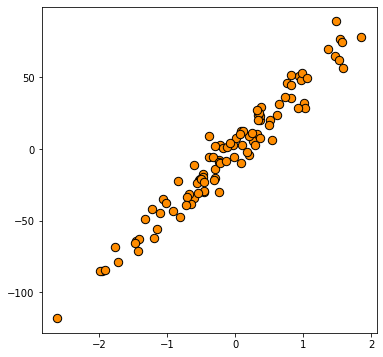

In [7]:
# сгенерируем данные
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [18]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(regression_data, 
                                                                    regression_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [19]:
#Создадим и обучим модель на тренировочных данных
tree_model = Tree(min_leaf=5, max_depth=3)
#tree_model = Tree(max_leaves=4)

my_tree = tree_model.build_tree(train_data, train_labels)


In [20]:
#Напечатаем дерево

tree_model.print_tree(my_tree)

УЗЕЛ: индекс = 0, порог = 0.09
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = -1.15
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -1.48
      --> Левая ветка:
          ЛИСТ: прогноз = -79.83830483283232, объектов = 5
      --> Правая ветка:
          ЛИСТ: прогноз = -60.95922383468576, объектов = 6
   --> Правая ветка:
       ЛИСТ: прогноз = -18.219302134821252, объектов = 29
--> Правая ветка:
    ЛИСТ: прогноз = 36.503080089657495, объектов = 30


In [22]:
#Получим ответы для обучающей выборки 
train_answers = tree_model.predict(train_data, my_tree)

In [23]:
# И получим ответы для тестовой выборки
answers = tree_model.predict(test_data, my_tree)

In [24]:
# Введем функцию подсчета ошибки MSE
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err

In [38]:
# Введем функцию подсчета ошибки r^2
def r2_score(y, y_hat):
    return 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)

In [25]:
#Ошибка на обучающей выборке
train_mse = calc_mse(train_labels, train_answers)
train_mse

364.28222383949276

In [40]:
#r^2 на обучающей выборке
train_r2_score = r2_score(train_labels, train_answers)
train_r2_score

0.801875958726322

In [27]:
#Ошибка на тестовой выборке_mse = calc_mse(train_labels, train_answers)
test_mse = calc_mse(test_labels, answers)
test_mse

431.2863467385858

In [41]:
#r^2 на тестовой выборке
test_r2_score = r2_score(test_labels, answers)
test_r2_score

0.6785113173877653